# Boosted Tree Documentation

### Author(s): [Ben Dykstra](https://github.com/bfdykstra)
### Date:  July, 2017
### Tags: #Data-science, #machine-learning, #hot-prospects, #boosted-trees

***
###	TLDR:
This notebook documents the various tuned models that take in different types of data to predict the number of leads that a property will recieve. The best model uses the raw data with no feature engineering done to it.
***

### Motivation

Clarifies some of the saved models so that we know which ones should be used in prediction.

In [74]:
import json
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import cross_validation, metrics
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
import seaborn as sns
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18.5, 10.5



predictors = ['golf_course', 'google_fiber',
       'verizon_fios', 'att_uverse', 'door_attendant', 'elevator',
       'utilities_included', 'vintage_building', 'smoke_free_community',
       'air_conditioning', 'all_dogs_allowed', 'cable_or_satellite',
       'cats_allowed', 'ceiling_fan', 'dishwasher', 'extra_storage',
       'large_dogs', 'laundry_facility', 'patio_or_balcony',
       'pets_allowed', 'pool', 'public_transportation',
       'small_dogs_allowed', 'view', 'walk_in_closets', 'hardwood_floor',
       'accepts_credit_card_payments', 'accepts_electronic_payments',
       'wireless_internet_access', 'broadband_internet_access',
       'business_center_onsite', 'club_house', 'controlled_access',
       'disability_access', 'fitness_center', 'garages', 'microwave',
       'washer_dryer_in_unit', 'luxury_amenities', 'furnished_available',
       'short_term_lease', 'covered_lot', 'fireplace', 'spa', 'playground',
       'tennis_court', 'washer_dryer_hookup', 'alarm_system',
       'hablamos_espanol', 'community_price', 'in_FL', 'in_CA']
groups = ['community_price', 'in_FL', 'in_CA', 'Group1', 'Group2', 'Group3', 'Group4', 'Group5', 'Group6', 'Group7']
target = 'digital_leads'

stem = '/Users/benjamin.dykstra/Documents/hot_prospects/data/'

data_list = ['city_level_raw_counts.csv', 'RelativeFreq_CityLevel.csv', 'Data_Group_RelativeFreq.csv']


model_names = ['raw count','only relative frequency', 'only groups', 'groups with all variables' ]
model_paths = ['/Users/benjamin.dykstra/Documents/hot_prospects/models/raw_cities_model.json',
              '/Users/benjamin.dykstra/Documents/hot_prospects/models/rel_freq.json',
              '/Users/benjamin.dykstra/Documents/hot_prospects/models/groups_only_rel_freq.json',
              '/Users/benjamin.dykstra/Documents/hot_prospects/models/groups_with_others_rel_freq.json']

A whole bunch of utility functions that are called throughout the notebook. Of note is the model fit function which fits the xgboost model using the parameters passed in to it.

In [75]:
"""Computes the root mean squared error"""
def rmse(y_actual, y_predicted):
    RMSE = mean_squared_error(y_actual, y_predicted)**0.5
    return RMSE

def plot_resids(y_pred, resid):
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    sns.regplot(y_pred, resid, ax=ax);
    
def modelfit(alg, dtrain, dtest, predictors, target = 'digital_leads', useTrainCV=True, cv_folds=5, 
             early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label = dtrain[target].values)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = alg.get_params()['n_estimators'], nfold = cv_folds,
            metrics=['rmse'], early_stopping_rounds = early_stopping_rounds, show_progress = False, seed = 27)
        print 'Stopped at round ', cvresult.shape[0]
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='rmse')
        
    #Predict training set:
    dtest_predictions = alg.predict(dtest[predictors])
    #print dtrain_predictions[:5]
    resid = dtest_predictions - dtest[target]
                        
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances', figsize = (18.5, 10.5))
    plt.ylabel('Feature Importance Score')
    
    plot_resids(dtest_predictions, resid)
    
    fig, ax = plt.subplots()
    fig.set_size_inches = (18.5, 10.5)
    fig.title = 'Residuals'
    sns.distplot(resid, ax = ax);
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % rmse(dtest[target].values, dtest_predictions)
    print "R2 Score (Train): %f" % alg.score(dtrain[predictors], dtrain[target])
    #print "R2 Score (Test): %f" % alg.score(dtest[predictors], dtest_predictions)
    print "residual mean: ", resid.mean()
    print "residual standard error: ", resid.std()
    print "Mean Prediction: ", dtest_predictions.mean()
    print "Median Prediction: ", np.median(dtest_predictions)
    
def city_state_split(data, col):
    city_state = pd.DataFrame(data[col].str.split(',').tolist())
    city_state = city_state.rename(columns={0:'city',1:'state'})
    city_state['state'] = city_state['state'].str.strip()
    return pd.concat([data, city_state], axis=1)


def preprocess_data(path, test_size, split_up = True, mark_FL_and_CA = True, divide_by_count = False ):
    df = pd.read_csv(path)
    
    if divide_by_count:
        df['digital_leads'] = df['digital_leads'].div(df['count_sites'], axis = 'index')
        
    if split_up:
        df = city_state_split(df, 'city_state')
    
    if mark_FL_and_CA:
        #mark places in FL and CA, a lot of super performers, helps algorithm reduce variance
        df['in_FL'] = 0
        df['in_CA'] = 0

        df.loc[df['state'] == 'FL', 'in_FL'] = 1
        df.loc[df['state'] == 'CA', 'in_CA'] = 1

    #split into training and testing
    train, test = cross_validation.train_test_split(df, test_size = test_size, random_state = 27)
    
    return train, test, df

#load json models in, return dictionary with names as keys and their corresponding parameter list as values
def get_models(model_paths, names):
    assert len(model_paths) == len(names)
    
    model_dict = {}
    for i in range(len(model_paths)):
        with open(model_paths[i]) as data_file:    
            model = json.load(data_file)
        #print model
        model_dict[names[i]] = model
        
    return model_dict

all_models = get_models(model_paths, model_names)

## Model for the raw count data

the optimized model using raw customer performance data.

Will train until cv error hasn't decreased in 50 rounds.


Stopped at round  77

Model Report
Accuracy : 616.1
R2 Score (Train): 0.993590
residual mean:  11.7406908737
residual standard error:  616.371995066
Mean Prediction:  481.275
Median Prediction:  146.4


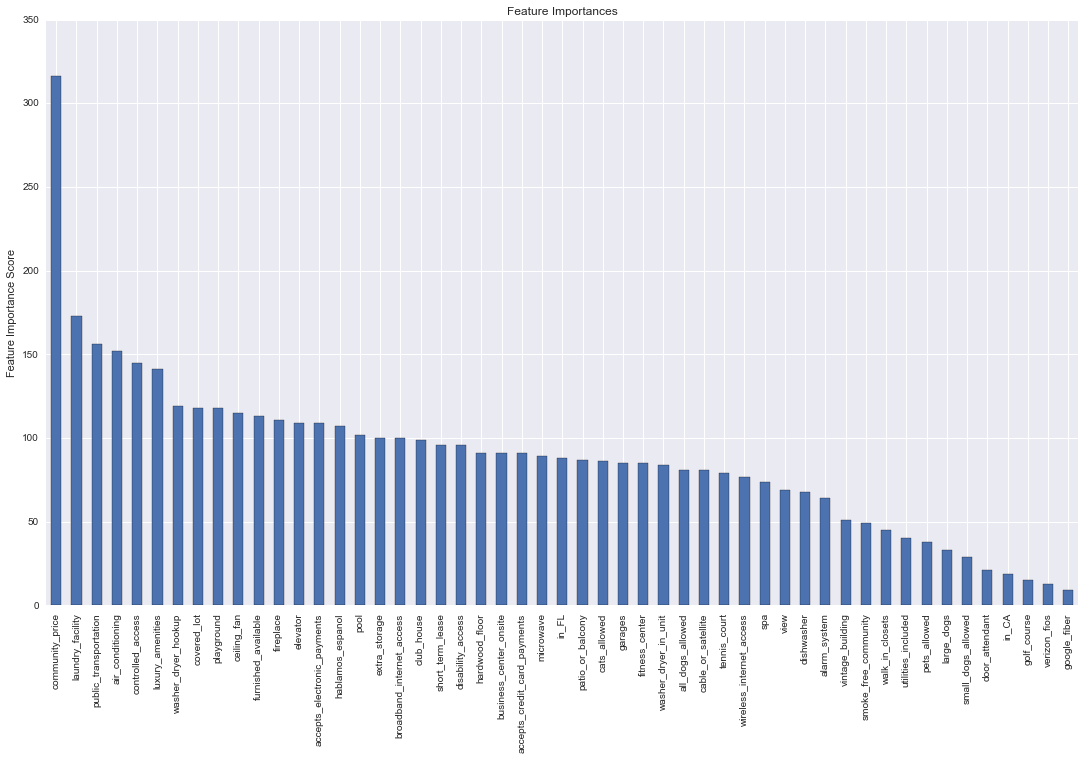

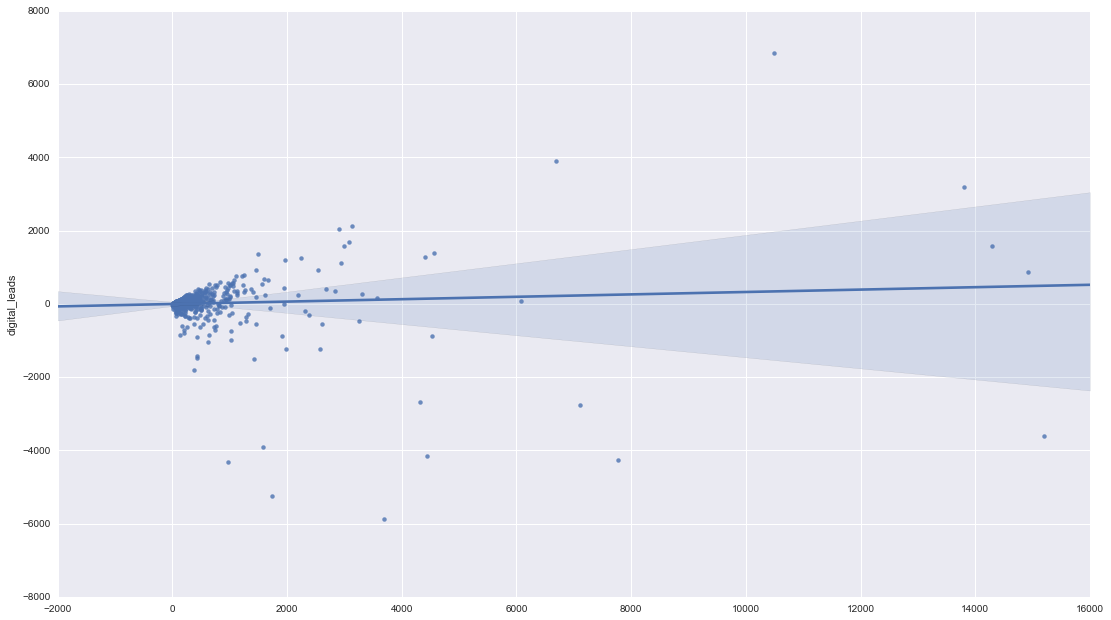

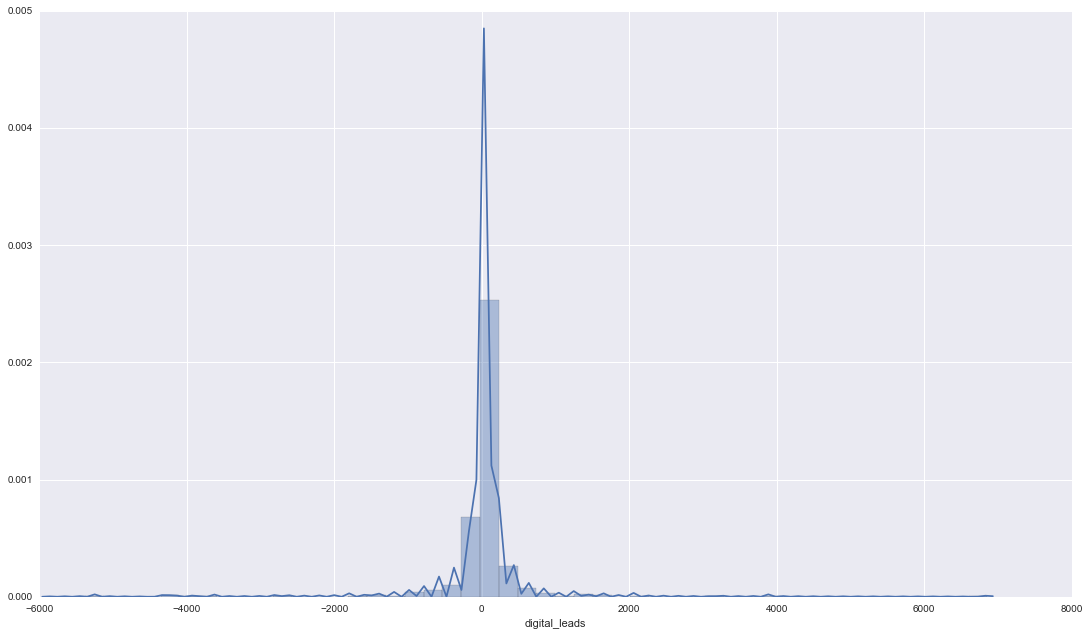

In [78]:
data_path = stem + data_list[0]

train_raw, test_raw, all_data = preprocess_data(data_path, test_size = 0.3)

#load model from model dictionary
raw_params = all_models['raw count']

xgb_raw = XGBRegressor(**raw_params)
modelfit(xgb_raw, train_raw, test_raw, predictors)

### For comparison's sake, some descriptive statistics about digital leads

count     2681.000000
mean       485.742633
std       1501.036834
min          0.000000
25%         36.000000
50%        107.000000
75%        338.000000
max      29492.000000
Name: digital_leads, dtype: float64


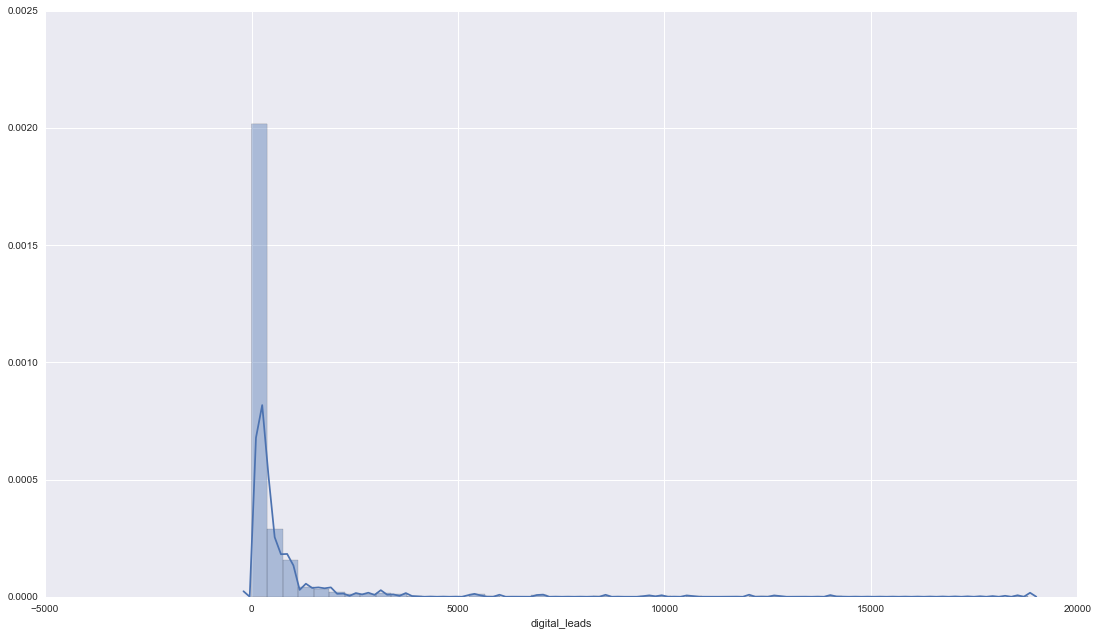

In [79]:
print all_data['digital_leads'].describe()
fig, ax = plt.subplots()
fig.set_size_inches = (18.5, 10.5)
sns.distplot(test_raw['digital_leads'], ax = ax);

Okay, so there are 6 cities with 0 digital leads. Relative to our sample size thats not huge so thats fine. Our standard deviation is about 1500 leads with a mean of 485.75 and a median of 107. So our distribution of leads is heavily skewed with 75% of the leads under 338.

The root mean squared error (rmse) of the raw model is 616.1. Relative to the variance of the leads (1500) this is pretty good and the R2 of the fit on the training data is very good at 99%.

The mean prediction is 481.275 and the median 146.4. The mean prediction matches up well with the true data, however, the median is pretty far off from 107.

## Model with just the groupings

These groupings were found via clustering.

Something to note, the digital leads are now on a per site basis. This means that the leads are scaled by the number of sites in a city. 


Will train until cv error hasn't decreased in 50 rounds.


Stopped at round  593

Model Report
Accuracy : 80.36
R2 Score (Train): 0.910881
residual mean:  -3.0320450221
residual standard error:  80.3483001181
Mean Prediction:  64.7099
Median Prediction:  58.167


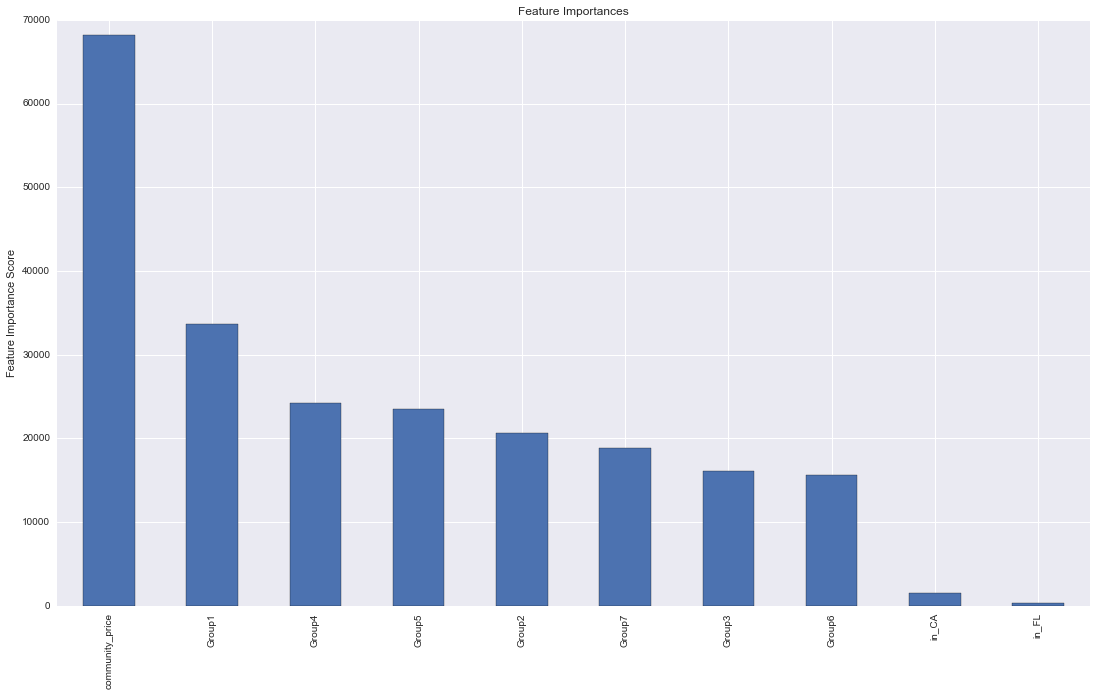

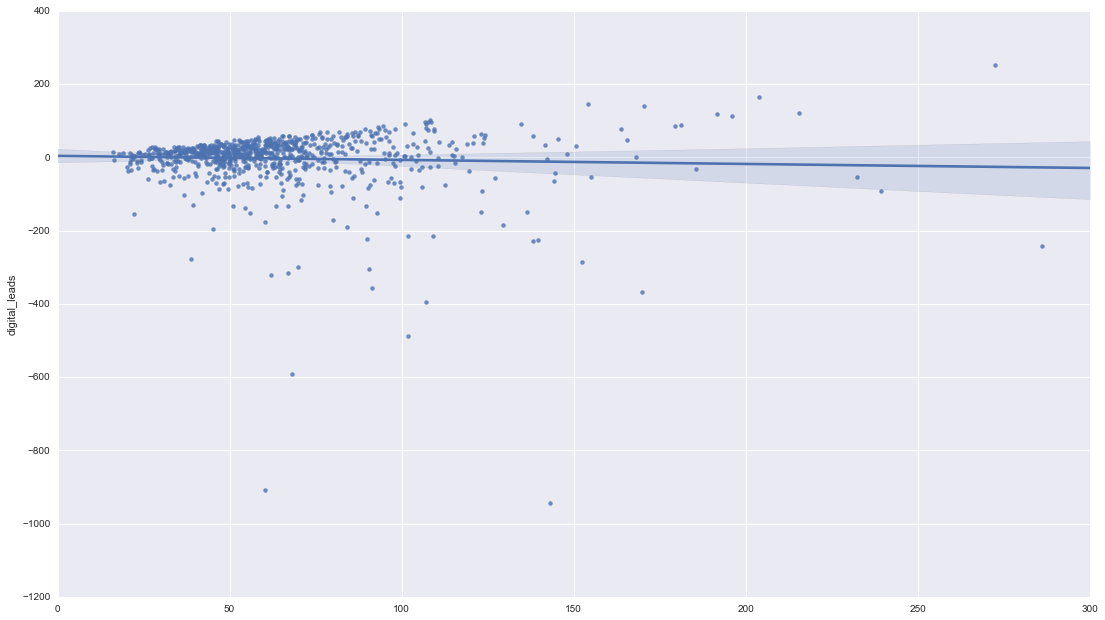

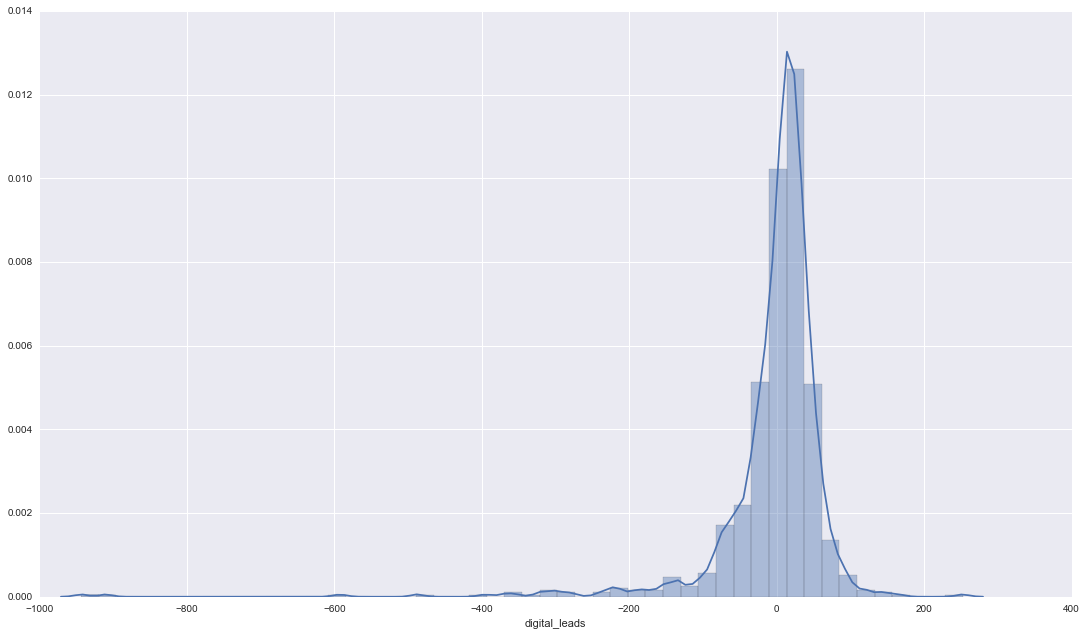

In [50]:
data_path = stem + data_list[2]

train_groups, test_groups, all_data = preprocess_data(data_path, test_size = 0.3)

#load model from model dictionary
group_params = all_models['only groups']

xgb_groups = XGBRegressor(**group_params)
modelfit(xgb_groups, train_groups, test_groups, groups)

Again, we look at how the leads are distributed in the dataset

In [41]:
all_data['digital_leads'].describe()

count    2681.000000
mean       67.239448
std        81.926243
min         0.000000
25%        24.000000
50%        44.000000
75%        81.333333
max      1092.000000
Name: digital_leads, dtype: float64

Our rmse is about the same as the standard deviation of the leads, and the mean of the predictions is fairly close to the true data. However, the median is still over shooting by about 14 leads. The residual mean is also pretty close to 0, with the model on average under predicting by 3 leads.

## Model with relative frequency of variables, no groups included

all amenity variables are included with this model, however none of the groupings of variables are included.

Will train until cv error hasn't decreased in 50 rounds.


Stopped at round  36

Model Report
Accuracy : 74.79
R2 Score (Train): 0.883996
residual mean:  2.41034403645
residual standard error:  74.7949473723
Mean Prediction:  70.1523
Median Prediction:  60.3394


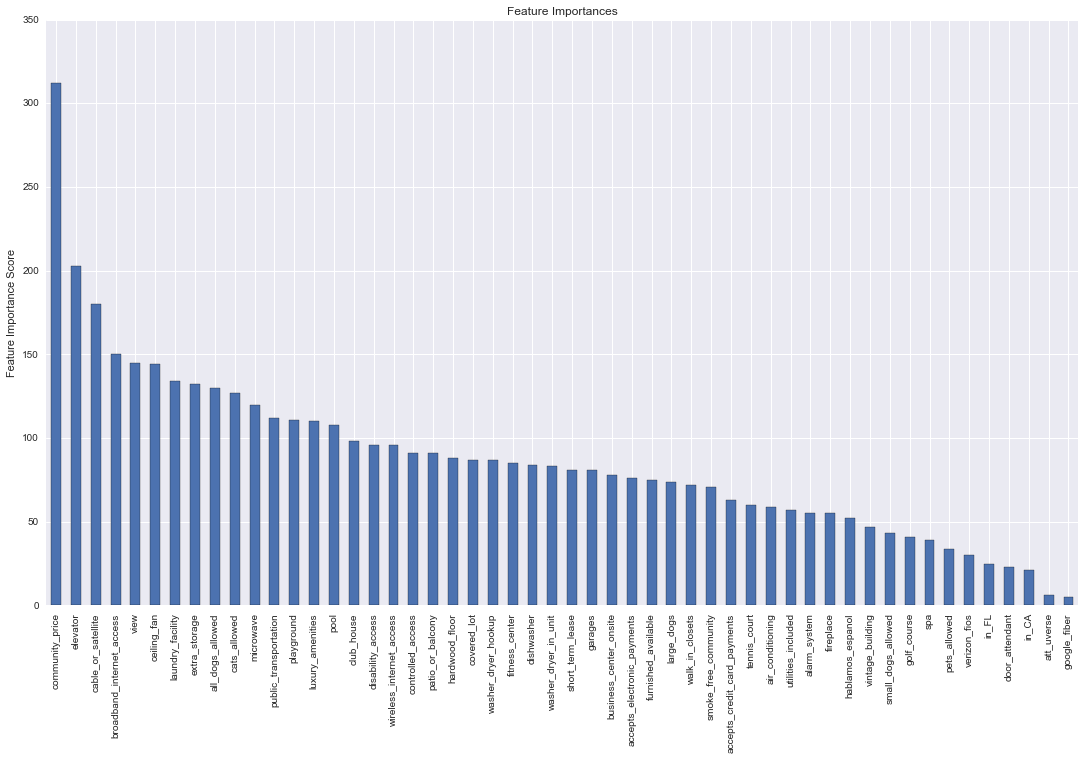

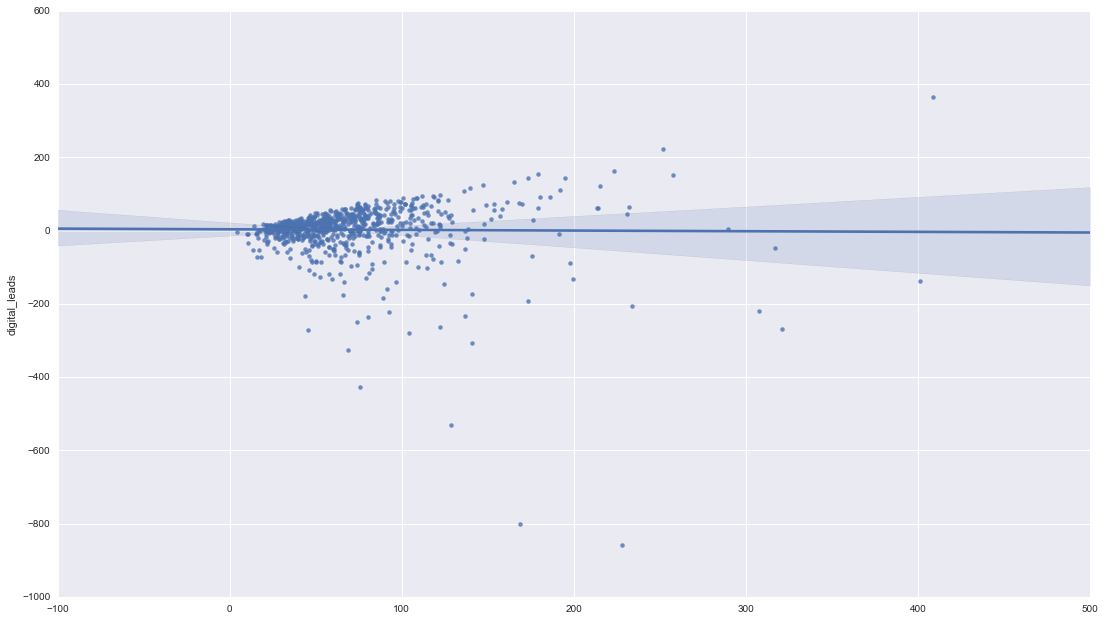

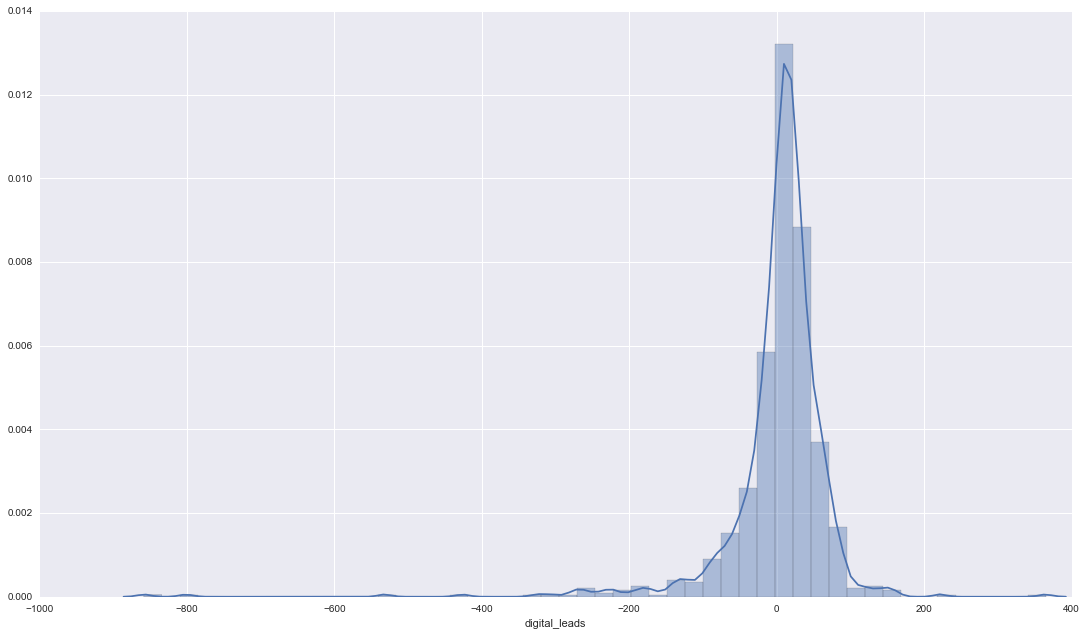

In [55]:
data_path = stem + data_list[1]

train_rel_freq, test_rel_freq, all_data = preprocess_data(data_path, test_size = 0.3)

#load model from model dictionary
rel_freq_params = all_models['only relative frequency']

xgb_rel_freq = XGBRegressor(**rel_freq_params)
modelfit(xgb_rel_freq, train_rel_freq, test_rel_freq, predictors)

This model is much better than the model with only the groups. The rmse is 74.79 where as the groupings only model was 80.36. The fit of on the training data is slightly worse with an R2 of 88.4 compared to 91. 

The model over predicts on average by about 2.4 with a standard deviation of 74.8 which again is better than the groupings only model

## Relative frequency with groupings

In [58]:
#need to append the groupings on to the predictors list
predictors = ['golf_course', 'google_fiber',
       'verizon_fios', 'att_uverse', 'door_attendant', 'elevator',
       'utilities_included', 'vintage_building', 'smoke_free_community',
       'air_conditioning', 'all_dogs_allowed', 'cable_or_satellite',
       'cats_allowed', 'ceiling_fan', 'dishwasher', 'extra_storage',
       'large_dogs', 'laundry_facility', 'patio_or_balcony',
       'pets_allowed', 'pool', 'public_transportation',
       'small_dogs_allowed', 'view', 'walk_in_closets', 'hardwood_floor',
       'accepts_credit_card_payments', 'accepts_electronic_payments',
       'wireless_internet_access', 'broadband_internet_access',
       'business_center_onsite', 'club_house', 'controlled_access',
       'disability_access', 'fitness_center', 'garages', 'microwave',
       'washer_dryer_in_unit', 'luxury_amenities', 'furnished_available',
       'short_term_lease', 'covered_lot', 'fireplace', 'spa', 'playground',
       'tennis_court', 'washer_dryer_hookup', 'alarm_system',
       'hablamos_espanol', 'community_price', 'in_FL', 'in_CA',
        'Group1', 'Group2', 'Group3', 'Group4', 'Group5', 'Group6', 'Group7']


Will train until cv error hasn't decreased in 50 rounds.


Stopped at round  750

Model Report
Accuracy : 75.65
R2 Score (Train): 0.863834
residual mean:  2.82821688317
residual standard error:  75.6399251141
Mean Prediction:  70.5702
Median Prediction:  62.5813


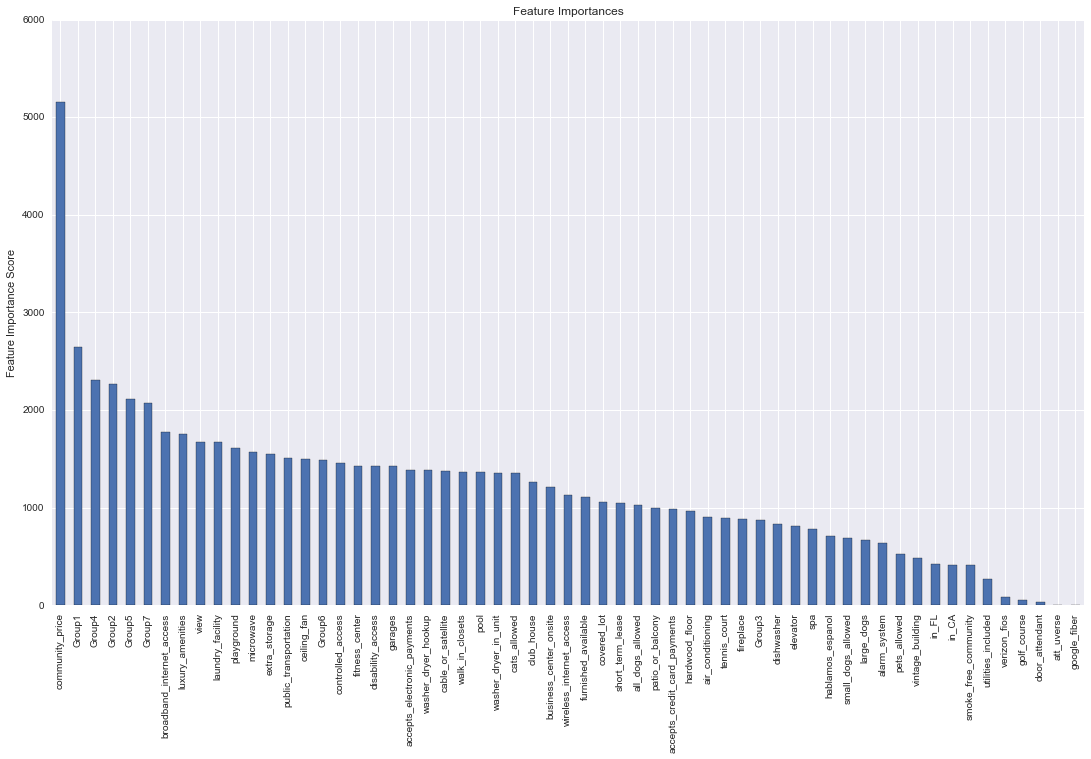

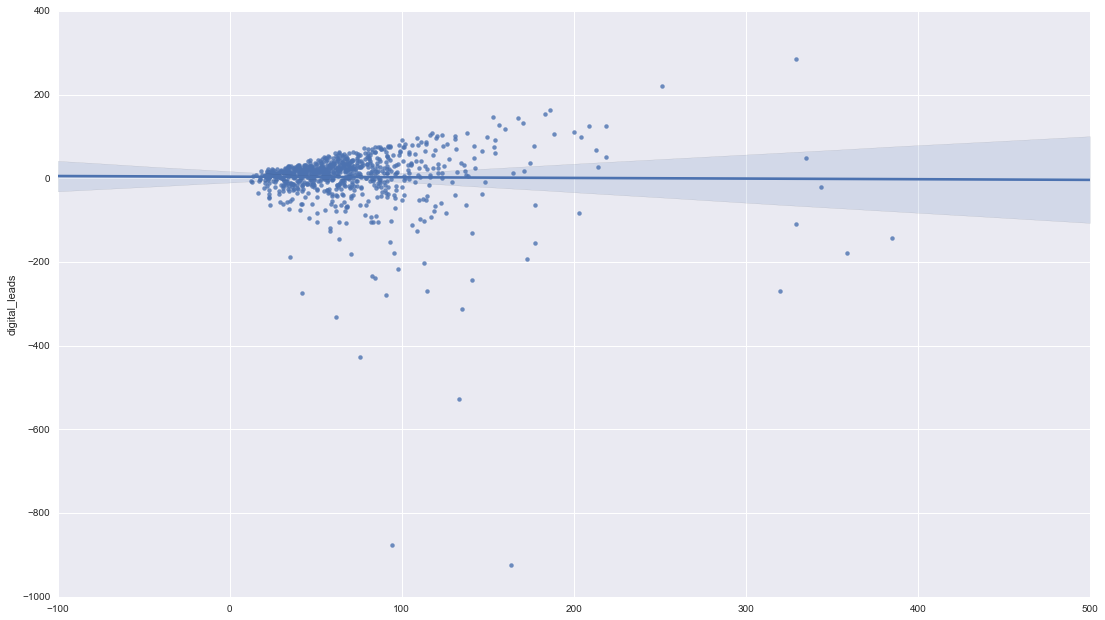

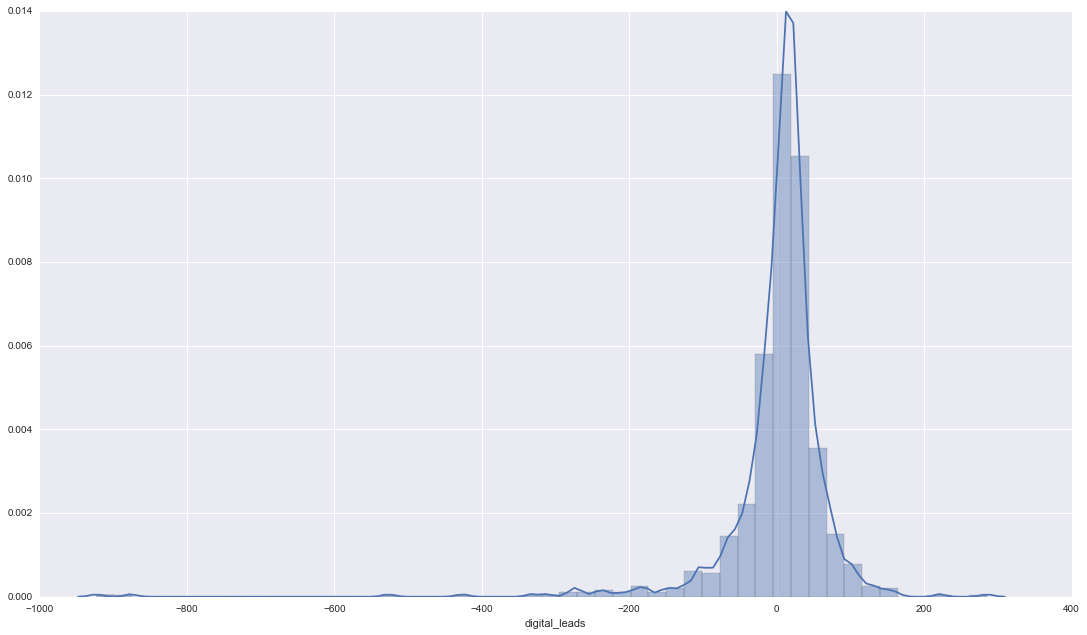

In [65]:

data_path = stem + data_list[2]

train_group_rel_freq, test_group_rel_freq, all_data = preprocess_data(data_path, test_size = 0.3)

#load model from model dictionary
group_rel_freq_params = all_models['groups with all variables']

xgb_group_rel_freq = XGBRegressor(**group_rel_freq_params)
modelfit(xgb_group_rel_freq, train_group_rel_freq, test_group_rel_freq, predictors)

The relative frequency model with the groupings is basically the same as the model with out the groupings in it. There is slightly more variance in the model with the groupings result in decreased accuracy. 

# The Definitive Ranking

 Strictly going off of the ratio of rmse to standard error, the raw count data wins by a long shot. 
 
1. The raw model. Highest R2 and lowest ratio of rmse to standard error
2. The model with just relative frequency variables. It had the highest accuracy at 74.79 and a high R2 at 0.883996.
3. The model with relative frequency AND groupings. Accuracy = 75.65 and R2 Score (Train)= 0.863834.
    

More work will be done on refining the raw model and trying raw groupings with it